# The Importance of Uncertainty in a Model

Uncertainty is a pivotal factor in machine learning and predictive models. It highlights the extent of confidence and potential errors in predictions, which is essential for making well-informed decisions. Uncertainty arises due to limited data, model complexity, measurement noise, and assumptions. Recognizing uncertainty is crucial as it aids in decision-making, risk assessment, and model selection. It also guides adaptation to new data and allows for better comparison between different models. Two primary uncertainty types are epistemic (model-related) and aleatoric (data-related). Conformal prediction provides a way to quantify uncertainty by creating prediction regions with defined probabilities, enhancing the reliability of machine learning applications.

# What is Conformal Prediction?

Conformal Prediction is a machine learning framework that provides a rigorous approach to uncertainty quantification in predictive models. Unlike traditional methods that yield point predictions, conformal prediction produces prediction regions with associated confidence levels. This allows us to express the uncertainty of individual predictions, offering a clearer understanding of a model's reliability.

The key idea behind conformal prediction is to treat each prediction as a hypothesis and assess its validity using a defined significance level. By constructing prediction regions that include a certain fraction of observed outcomes during training, the framework ensures that the true label lies within the predicted region with a high probability. Conformal Prediction is applicable to a wide range of machine learning algorithms and doesn't rely on specific distributional assumptions, making it a versatile tool for enhancing prediction confidence.


## Conformal Prediction for General Input and Output

Conformal Prediction is a powerful framework that can be applied to general input-output scenarios, not necessarily limited to discrete outputs. The algorithm can be outlined as follows:

1. **Heuristic Notion of Uncertainty**: Begin with a pre-trained model that provides predictions for input-output pairs. The model should have an associated heuristic notion of uncertainty that reflects its reliability in making predictions.

2. **Score Function Definition**: Define a score function $s(x, y) \in \mathbb{R}$, where larger scores indicate worse agreement between input $x$ and output $y$. This function captures the discrepancy between the predicted output and the true output.

3. **Quantile Computation**: Compute the estimated quantile $\hat{q}$ as the $(d(n+1)(1-\alpha))$-th quantile of the calibration scores $s_1 = s(X_1, Y_1), ..., s_n = s(X_n, Y_n)$. Here, $n$ is the number of calibration instances, $d$ is the number of potential outputs, and $\alpha$ controls the desired confidence level.

4. **Prediction Set Formation**: Utilize the computed quantile to form prediction sets for new input examples $X_{\text{test}}$:
   
   
   $$ C(X_{\text{test}}) = \{ y : s(X_{\text{test}}, y) \leq \hat{q} \} $$
   
   The prediction set $C(X_{\text{test}})$ contains all potential outputs $y$ that have a score $s(X_{\text{test}}, y)$ within the estimated quantile $\hat{q}$. This set defines the prediction region for the new example.

This algorithm leverages the model's score function and the quantile of calibration scores to construct prediction sets for new input examples. These prediction sets provide a measure of uncertainty and reliability associated with the model's predictions in a wide range of scenarios.



In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

torch.manual_seed(42)
np.random.seed(42)

In [9]:
def get_simple_data_train(coef_1, coef_2, coef_3, coef_4, n_cal):
    print("running simple data")
    # Generate data points for the custom function with some noise
    x = np.linspace(-.2, 0.2, 300)
    x = np.hstack([x, np.linspace(.6, 1, 300)])
    eps = 0.1 * np.random.randn(x.shape[0])
    y = coef_1 * np.sin(2 * np.pi*(x)) + coef_2 * np.cos(4 * np.pi *(x)) + coef_3 * x+ eps
    x = torch.from_numpy(x).float()[:, None]
    y = torch.from_numpy(y).float()
    print("running regression data")
    # Split data into calibration and training sets
    cal_idx = np.random.choice(x.shape[0], n_cal, replace=False)
    mask = np.zeros(len(x), dtype=bool)
    mask[cal_idx] = True
    x_cal, y_cal = x[mask], y[mask]
    x_train, y_train = x[~mask], y[~mask]
    return x_train, y_train, x_cal, y_cal

In [10]:
def plot_generic(_x_train, _y_train, _x_cal, _y_cal, _add_to_plot=None, coef_1=0.3, coef_2=0.02, coef_3=0.1, coef_4=0.02):
    # print("running plot_generic")
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlim([-.5, 1.5])
    plt.ylim([-1.5, 2.5])
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)
    plt.title("Plot of Training and Calibration Data with True Function", fontsize=20)

    # Generate true function curve
    x_true = np.linspace(-.5, 1.5, 1000)
    y_true = coef_1 * np.sin(2 * np.pi * x_true) + coef_2 * np.cos(4 * np.pi * x_true) + coef_3 * x_true
    # print(_x_train.shape, _y_train.shape, _x_cal.shape, _y_cal.shape)

    # Plot training data as green scatter points
    ax.scatter(_x_train, _y_train, c='green', s=10, label="training data")

    # Plot calibration data as red scatter points
    ax.scatter(_x_cal, _y_cal, c='red', s=10, label="calibration data")

    # Plot the true function as a blue line
    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")

    # If additional plot elements are provided, add them using the '_add_to_plot' function
    if _add_to_plot is not None:
        _add_to_plot(ax)

    # Add a legend to the plot
    plt.legend(loc='best', fontsize=15, frameon=False)

    return fig, ax


In [11]:
coef_1 = 0.3
coef_2 = 0.3
coef_3 = 0.1
coef_4 = 0.3
n_cal = 500
x_train, y_train, x_cal, y_cal = get_simple_data_train(coef_1, coef_2, coef_3, coef_4, n_cal)

running simple data
running regression data


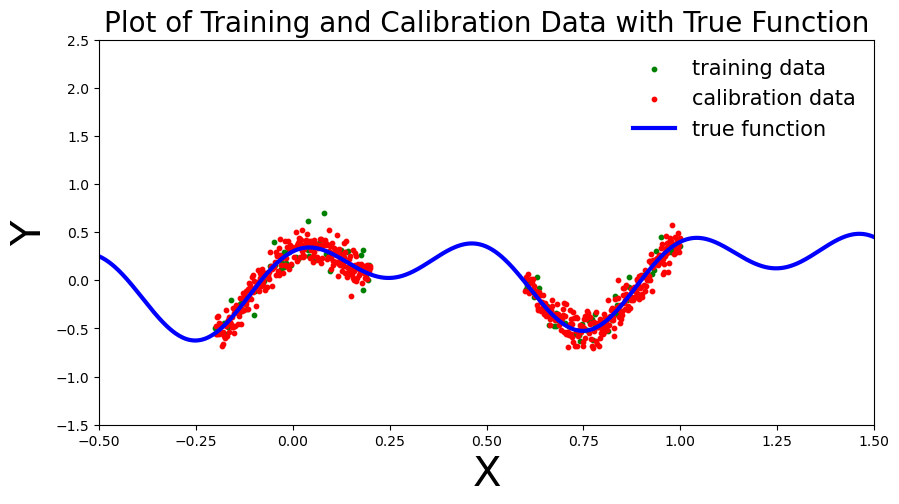

(None,)

In [12]:
plot_generic(x_train, y_train, x_cal, y_cal, coef_1=coef_1, coef_2=coef_2, coef_3=coef_3, coef_4=coef_4)
plt.show(),

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.Tanh()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)

            hidden = hidden_temp + hidden  # residual connection

        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean

In [14]:
def train(net, train_data):
    x_train, y_train = train_data
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    progress_bar = trange(3000)
    for _ in progress_bar:
        optimizer.zero_grad()
        loss = criterion(y_train, net(x_train))
        progress_bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
        loss.backward()
        optimizer.step()
    return net

In [15]:
def plot_predictions(_x_train, _y_train, _x_cal, _y_cal, _x_test, _y_preds, coef_1=0.3, coef_2=0.02, coef_3=0.1, coef_4=0.02):
    # print("running predictions")
    def add_predictions(ax):
        # Plot the neural network prediction curve as a line
        ax.plot(_x_test, _y_preds, 'y-', linewidth=3, label='neural net prediction')
    fig, ax = plot_generic(_x_train, _y_train, _x_cal, _y_cal, add_predictions, coef_1, coef_2, coef_3, coef_4)
    plt.title("Plot of Training, Calibration, and Neural Network Predictions", fontsize=15)
    return fig, ax

In [16]:
net = MLP(hidden_dim=30, n_hidden_layers=2)
net = train(net, (x_train, y_train))


  0%|          | 0/3000 [00:00<?, ?it/s]

In [17]:
# compute predictions everywhere
x_test = torch.linspace(-.5, 1.5, 1000)[:, None]

In [18]:
plot_predictions(x_train, y_train, x_cal, y_cal, x_test, y_preds, coef_1=coef_1, coef_2=coef_2, coef_3=coef_3, coef_4=coef_4)
plt.show(),

NameError: name 'y_preds' is not defined

# Scoring Function

# $$s_i = |y_i - \hat{y}_i|$$

In [19]:
y_cal_preds = net(x_cal).detach().numpy()
scores = torch.abs(y_cal - y_cal_preds)

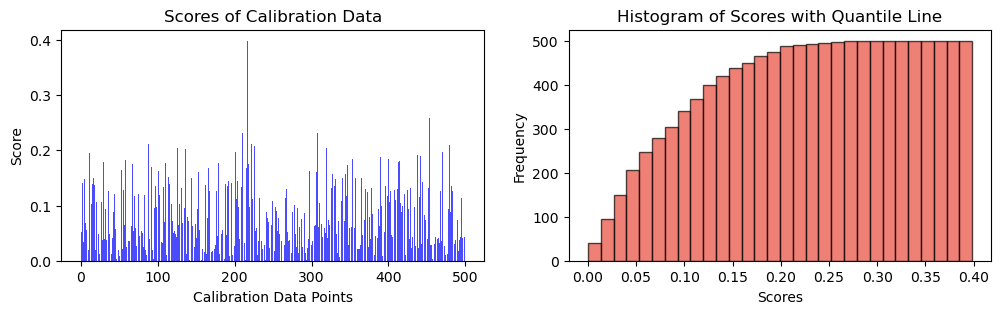

(None,)

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
# Plot scores of calibration data
ax[0].bar(np.arange(len(scores)), height = scores, alpha = 0.7, color = 'b')
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Calibration Data Points")
ax[0].set_title("Scores of Calibration Data")

# Plot the histogram
n, bins, _ = ax[1].hist(scores, bins=30, alpha=0.7, cumulative = True, color='#E94B3CFF', edgecolor='black', label='Score Frequency')
ax[1].set_xlabel('Scores')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Scores with Quantile Line')
plt.show(),

In [7]:
alpha = 0.1

# $$q = \frac{{\lceil (1 - \alpha) \cdot (n + 1) \rceil}}{{n}}$$

In [93]:
q_val = np.ceil((1 - alpha) * (n_cal + 1)) / n_cal
print(f"q_val: {q_val}")

q_val: 0.902


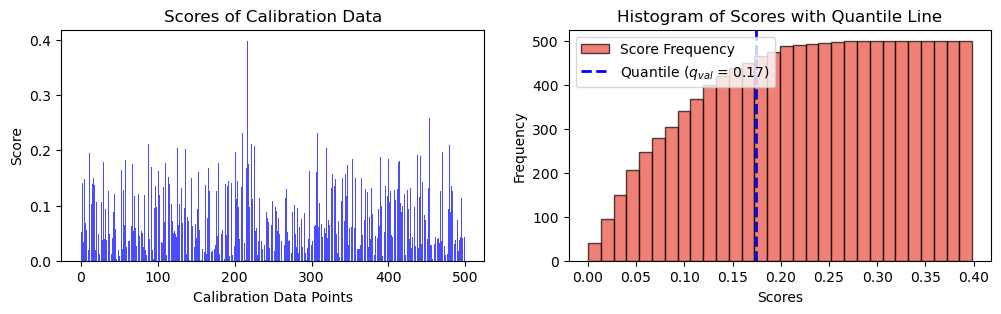

(None,)

In [95]:
q = np.quantile(scores, q_val, method="higher")
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
# Plot scores of calibration data
ax[0].bar(np.arange(len(scores)), height = scores, alpha = 0.7, color = 'b')
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Calibration Data Points")
ax[0].set_title("Scores of Calibration Data")

# Plot the histogram
n, bins, _ = ax[1].hist(scores, bins=30, alpha=0.7, cumulative = True, color='#E94B3CFF', edgecolor='black', label='Score Frequency')

# Plot the vertical line at the quantile
# q_x = np.quantile(scores, q)
ax[1].axvline(q, color='b', linestyle='dashed', linewidth=2, label=r"Quantile (${q_{val}}$ = " + str(("{:.2f}")).format(q) + ")")

ax[1].set_xlabel('Scores')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Scores with Quantile Line')
plt.legend()
plt.show(),

In [98]:
def plot_conformal_prediction( _x_train, _y_train, _x_cal, _y_cal, _x_test, _y_preds, q, coef_1, coef_2, coef_3, alpha):
    x_true = np.linspace(-.5, 1.5, 1000)
    y_true = coef_1 * np.sin(2 * np.pi*(x_true)) + coef_2 * np.cos(4 * np.pi *(x_true )) + coef_3 * x_true
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlim([-.5, 1.5])
    plt.ylim([-1.5, 2.5])
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(_x_train, _y_train, 'go', markersize=4, label="training data")
    ax.plot(_x_cal, _y_cal, 'ro', markersize=4, label="calibration data")
    ax.plot(_x_test, _y_preds, '-', linewidth=3, color="y", label="predictive mean")
    ax.fill_between(_x_test.ravel(), _y_preds - q, _y_preds + q, alpha=0.6, color='y', zorder=5)

    plt.legend(loc='best', fontsize=15, frameon=False)
    
    cov = np.mean(((_y_preds - q) <= y_true) * ((_y_preds + q) >= y_true))
    plt.title("Plot of confidence interval for the conformal prediction", fontsize=15)

# $$\hat{C}(X_{n+1}) = [ \hat{f}(x_{n+1}) - {q_{val}}, \, \hat{f}(x_{n+1}) + {q_{val}} ]$$

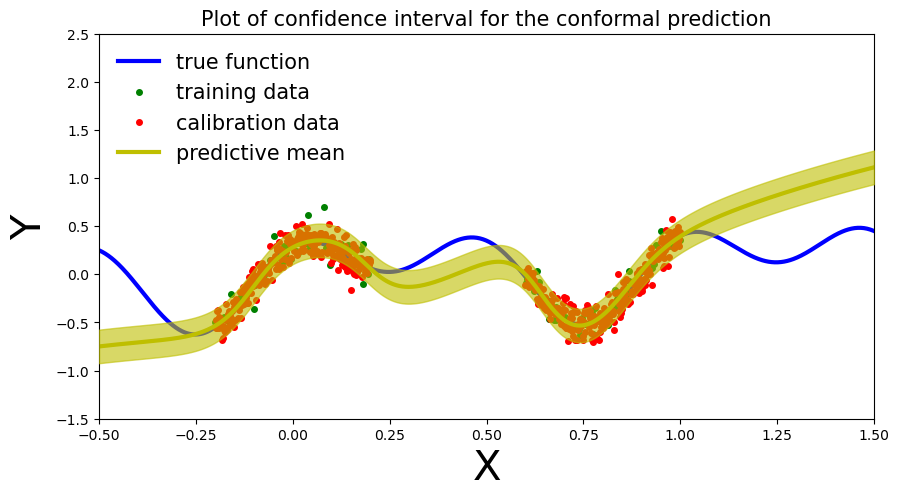

In [99]:
plot_conformal_prediction(x_train, y_train, x_cal, y_cal, x_test, y_preds, q, coef_1, coef_2, coef_3, alpha)